# Surface tension calculations using DFT for Deuterium-Hydrogen mixtures
Classical density functional theory for interfacial properties of hydrogen, helium, deuterium, neon and their mixtures ([doi:10.1063/5.0137226](https://doi.org/10.1063/5.0137226))

In [1]:
from feos import *
from feos.dft import *
from feos.saftvrqmie import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import si_units as si
import seaborn as sns
import tqdm
import json

sns.set_context('talk')
sns.set_palette('Dark2')
sns.set_style('ticks')

# Set up functional

In [2]:
parameters = SaftVRQMieParameters.from_json(["deuterium", "hydrogen"], 
                                            "../../parameters/saftvrqmie/hammer2023.json", 
                                            binary_path="../../parameters/saftvrqmie/aasen2020_binary.json")
eos = HelmholtzEnergyFunctional.saftvrqmie(parameters)

## Critcal temperature estimate

In [3]:
cp = State.critical_point(eos, np.array([0.5, 0.5]) * si.MOL, initial_temperature=35*si.KELVIN)

# Load experimental data
Grigorev and Rudenko.
*Surface tension of liquid hydrogen isotopes and hydrogen-deuterium solutions.*
Sov. phys. JETP 1965

In [4]:
data = np.loadtxt("./data/hydrogen_deuterium_exp_data.dat", skiprows=1)

# Map isotherms for T=18.88 K and T=20.44 K

In [5]:
dia_18 = PhaseDiagram.binary_vle(eos, 18.88 * si.KELVIN, npoints=21)
vle0 = [PhaseEquilibrium.bubble_point(eos, 18.88 * si.KELVIN, np.array([1e-10, 1-1e-10]))]
vle1 = [PhaseEquilibrium.bubble_point(eos, 18.88 * si.KELVIN, np.array([1- 1e-10, 1e-10]))]
sft_dia_18 = SurfaceTensionDiagram(vle0 + dia_18.states + vle1, n_grid=1024)

In [6]:
dia_20 = PhaseDiagram.binary_vle(eos, 20.44 * si.KELVIN, npoints=21)
vle0 = [PhaseEquilibrium.bubble_point(eos, 20.44 * si.KELVIN, np.array([1e-10, 1-1e-10]))]
vle1 = [PhaseEquilibrium.bubble_point(eos, 20.44 * si.KELVIN, np.array([1- 1e-10, 1e-10]))]
sft_dia_20 = SurfaceTensionDiagram(vle0 + dia_20.states + vle1, n_grid=1024)

In [7]:
def surftens_mulero2012(fluid, tr):
    """
    Calculate pure fluid surface tension using Mulero et al. 2012 correlation (doi:10.1063/1.4768782)
    Args:
        fluid (str): Component name
        tr (np.ndarray): Reduced temperature
    Returns:
        sigma (np.ndarray): Surface tension (mN/m)
    """
    ff = open("mulero_2012_parameters.json", "r")
    complist = json.load(ff)
    ff.close()
    sigma = np.zeros_like(tr)
    for i in range(len(complist[fluid]["sigma"])):
        sigma[:] += complist[fluid]["sigma"][i] * \
            (1-tr[:])**complist[fluid]["n"][i]
    return sigma * si.NEWTON / si.METER / (si.MILLI * si.NEWTON/  si.METER)
s_h2_20 = surftens_mulero2012("hydrogen", np.array([20.44/33.145]))
s_d2_20 = surftens_mulero2012("deuterium", np.array([20.44/38.34]))
s_h2_18 = surftens_mulero2012("hydrogen", np.array([18.88/33.145]))
s_d2_18 = surftens_mulero2012("deuterium", np.array([18.88/38.34]))

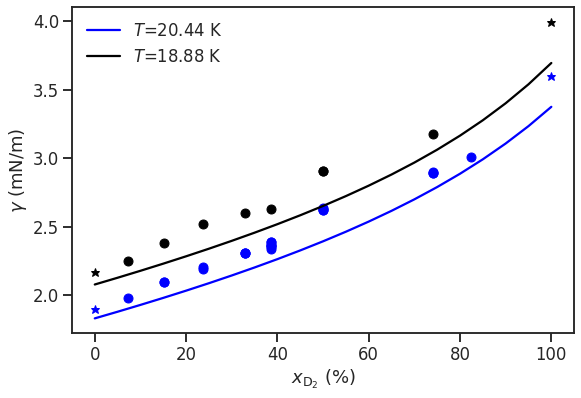

In [8]:
plt.figure(figsize=(9, 6))
colors = ["k","g","r","b","grey","orange","cyan"]
data_filter = np.isclose(data[:, 1], 20.44, atol=0.2)
plt.plot(sft_dia_20.liquid.molefracs[:,0]*100, sft_dia_20.surface_tension / (si.MILLI* si.NEWTON / si.METER), label='$T$=20.44 K', color="b")
plt.plot(data[data_filter, 0], data[data_filter, 2], linestyle="None", marker="o", color="b")
plt.plot(np.array([0.0]), s_h2_20, linestyle="None", marker="*", color="b")
plt.plot(np.array([100.0]), s_d2_20, linestyle="None", marker="*", color="b")

data_filter = np.isclose(data[:, 1], 18.88, atol=0.2)
plt.plot(sft_dia_18.liquid.molefracs[:,0]*100, sft_dia_18.surface_tension / (si.MILLI* si.NEWTON / si.METER), label='$T$=18.88 K', color="k")
plt.plot(data[data_filter, 0], data[data_filter, 2], linestyle="None", marker="o", color="k")
plt.plot(np.array([0.0]), s_h2_18, linestyle="None", marker="*", color="k")
plt.plot(np.array([100.0]), s_d2_18, linestyle="None", marker="*", color="k")

plt.xlabel(r'$x_{\rm{D}_2}$ (%)')
plt.ylabel(r'$\gamma$ (mN/m)')
leg = plt.legend(loc='best', frameon=False)

# DFT for all experimental data

In [9]:
states = []
for i in range(np.shape(data)[0]):
    T = data[i,1]
    c_D2 = data[i,0]
    surftens_exp = data[i,2]
    x = np.array([c_D2, 100.0-c_D2])/100.0
    vle = PhaseEquilibrium.bubble_point(eos, T * si.KELVIN, x)
    cp = State.critical_point(eos, x * si.MOL, initial_temperature=35.0*si.KELVIN) #, verbosity=Verbosity.Iter)
    states.append([vle, cp, surftens_exp, T])

In [10]:
sft = []
for vle, cp, s_exp, T in tqdm.tqdm(states):
    try:
        sft.append({ 
            "dft": PlanarInterface.from_tanh(vle, 1024, 200 * si.ANGSTROM, cp.temperature).solve().surface_tension / (si.MILLI  * si.NEWTON / si.METER),
            "exp": s_exp,
            "temp": T
        })
    except Exception as e:
        print(e)
        print(vle)

100%|██████████| 68/68 [01:03<00:00,  1.08it/s]


# Plot error map

In [11]:
df = pd.DataFrame(sft)

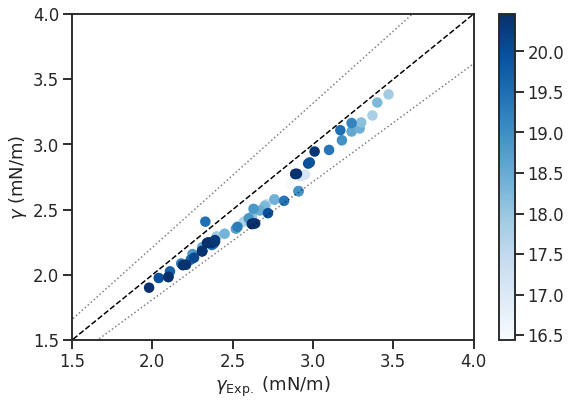

In [12]:
plt.figure(figsize=(9, 6))
smax = 4
err_fan = 0.1
df = pd.DataFrame(sft)
plt.scatter(df.exp, df.dft, c=df.temp, cmap='Blues', marker="o")
plt.plot([0, smax], [0, smax], color="black", linestyle="dashed", alpha=1.0, lw=1.5)
plt.plot([0, smax*(1+err_fan/2)], [0, smax*(1-err_fan/2)], color="black", linestyle="dotted", alpha=0.5, lw=1.5)
plt.plot([0, smax*(1-err_fan/2)], [0, smax*(1+err_fan/2)], color="black", linestyle="dotted", alpha=0.5, lw=1.5)
plt.ylabel(r'$\gamma$ (mN/m)')
plt.xlabel(r'$\gamma_{\rm{Exp.}}$ (mN/m)')
plt.xlim(1.5, smax)
plt.ylim(1.5, smax)
plt.colorbar()

# Calculate mean absolute deviation (MAD)

In [13]:
mad = 100*np.sum(np.abs((df.dft-df.exp)/df.exp))/df.exp.shape[0]
print(f"MAD={mad:.1f} %")

MAD=5.4 %
